In [1]:
import matplotlib.pyplot as plt

import numpy as np
import random
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import sys
from datetime import datetime
now = datetime.now

%cd adas_system/notebooks

try:
    USE_TPU = bool(os.environ['COLAB_TPU_ADDR'])
except:
    USE_TPU = False

if USE_TPU:
    # !pip uninstall pytorch
    # !pip install cloud-tpu-client==0.10 torch==1.10.0
    # !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
    import torch_xla
    import torch_xla.core.xla_model as xm
    USE_TPU = True

else:
    USE_TPU = False

IN_COLAB = False
import torch
from torch import nn

try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
    drive.mount('/content/drive')
    if not os.path.isfile('1.0.ClassifierResearch.ipynb'):
        print('already exist')
        !git clone --branch 9_SignDetector https://github.com/lsd-maddrive/adas_system.git
        !gdown --id 1-l3VvU-WtSoXbW_AaTFUreVD-tgXV8Q0
        %cd adas_system/notebooks
        !unzip -q -o /content/STOCK_SIGNS.zip -d ./../data/

except:
    if IN_COLAB:
        !git clone --branch 9_SignDetector https://github.com/lsd-maddrive/adas_system.git
        !gdown --id 1-l3VvU-WtSoXbW_AaTFUreVD-tgXV8Q0
        %cd adas_system/notebooks
        !mkdir ../data/rtsd-frames
        !unzip -q -o /content/STOCK_SIGNS.zip -d ./../data/
    else:
        pass

###
import nt_helper
from nt_helper.helper_utils import *
###

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
%matplotlib inline
plt.rcParams["figure.figsize"] = (17,10)

if USE_TPU:
    device = xm.xla_device()
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
LARGE = False
if LARGE:
    device = torch.device('cpu')
    
device

[WinError 3] The system cannot find the path specified: 'adas_system/notebooks'
D:\d_tsw\1_SIGN_CLASSIFIER\notebooks
helper init success


device(type='cuda')

In [2]:
if not IN_COLAB:
    PROJECT_ROOT = pathlib.Path(os.path.join(os.curdir, os.pardir))
else:
    PROJECT_ROOT = pathlib.Path('..')
    
DATA_DIR = PROJECT_ROOT / 'data'
NOTEBOOKS_DIR = PROJECT_ROOT / 'notebooks'

VIDEO_DIR = DATA_DIR / 'reg_videos'
video_path = str(VIDEO_DIR / '1.mp4')
print(video_path)

..\data\reg_videos\1.mp4


In [3]:
from models.yolo import Model
from torchvision import models

if LARGE:
    YOLO_CHECKPOINT_LOCATION = DATA_DIR / 'YoloV5L.pt'
    model_cfg_file = DATA_DIR / 'yolov5l_custom_anchors.yaml'
else:
    YOLO_CHECKPOINT_LOCATION = DATA_DIR / 'YoloV5.pt'
    model_cfg_file = DATA_DIR / 'yolov5s_custom_anchors.yaml'   
    
DETECTOR = Model(cfg=model_cfg_file, ch=3, nc=1)
DETECTOR.load_state_dict(torch.load(YOLO_CHECKPOINT_LOCATION, map_location=device))
DETECTOR_DETECT_INTEFACE = makeDetectFromModel(DETECTOR)
DETECTOR.eval()

USE_LAST = True


CLASSIFIER = models.resnet18()
MODEL_CLASSES = 57
CLASSIFIER.fc = nn.Sequential(
        nn.Linear(512, MODEL_CLASSES),
        nn.Softmax(dim=1)
)

if USE_LAST == True:
    CLASSIFIER_CHECKPOINT_LOCATION = DATA_DIR / 'classifier_check_point'
    ckpt = torch.load(CLASSIFIER_CHECKPOINT_LOCATION)
    model_dict = ckpt['model']
    CLASSIFIER.load_state_dict(model_dict)
else:
    CLASSIFIER_CHECKPOINT_LOCATION = DATA_DIR / 'CLASSIFIER_ON_STOCK'
    CLASSIFIER.load_state_dict(torch.load(CLASSIFIER_CHECKPOINT_LOCATION, map_location=device))
    
CLASSIFIER.to(device)
CLASSIFIER.eval()

DETECTOR_DETECT_INTEFACE.to(device)

from sklearn import preprocessing

LE_LOCATION = DATA_DIR / 'STOCK_SIGNS_LE.npy'
le = preprocessing.LabelEncoder()
le.classes_ = np.load(LE_LOCATION, allow_pickle=True)

print('[+] SUCCESS')

Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]             

[+] SUCCESS


In [4]:
PLOT_SUBS = True
SUPPRESS_TEXT = True

if PLOT_SUBS:
    STOCK_SIGNS_CSV_LOCATION = DATA_DIR / 'STOCK_SIGNS.csv'
    STOCK_SIGNS_DATAFRAME = pd.read_csv(STOCK_SIGNS_CSV_LOCATION)
    STOCK_SIGNS_DATAFRAME['filepath'] = STOCK_SIGNS_DATAFRAME['filepath'].apply(lambda x: str(x).replace('\\', '/'))
    STOCK_SIGNS_DATAFRAME['filepath'] = STOCK_SIGNS_DATAFRAME['filepath'].apply(lambda x: str(DATA_DIR / x))
else:
    STOCK_SIGNS = None
    
STOCK_SIGNS_DATAFRAME[::5]

,filepath,SIGN
0,..\data\STOCK_SIGNS\1.1.png,1.1
5,..\data\STOCK_SIGNS\1.8.png,1.8
10,..\data\STOCK_SIGNS\2.5.png,2.5
15,..\data\STOCK_SIGNS\3.22.png,3.22
20,..\data\STOCK_SIGNS\3.24.120.png,3.24.120
25,..\data\STOCK_SIGNS\3.24.50.png,3.24.50
30,..\data\STOCK_SIGNS\3.25.10.png,3.25.10
35,..\data\STOCK_SIGNS\3.25.20.png,3.25.20
40,..\data\STOCK_SIGNS\3.25.70.png,3.25.70
45,..\data\STOCK_SIGNS\3.31.png,3.31


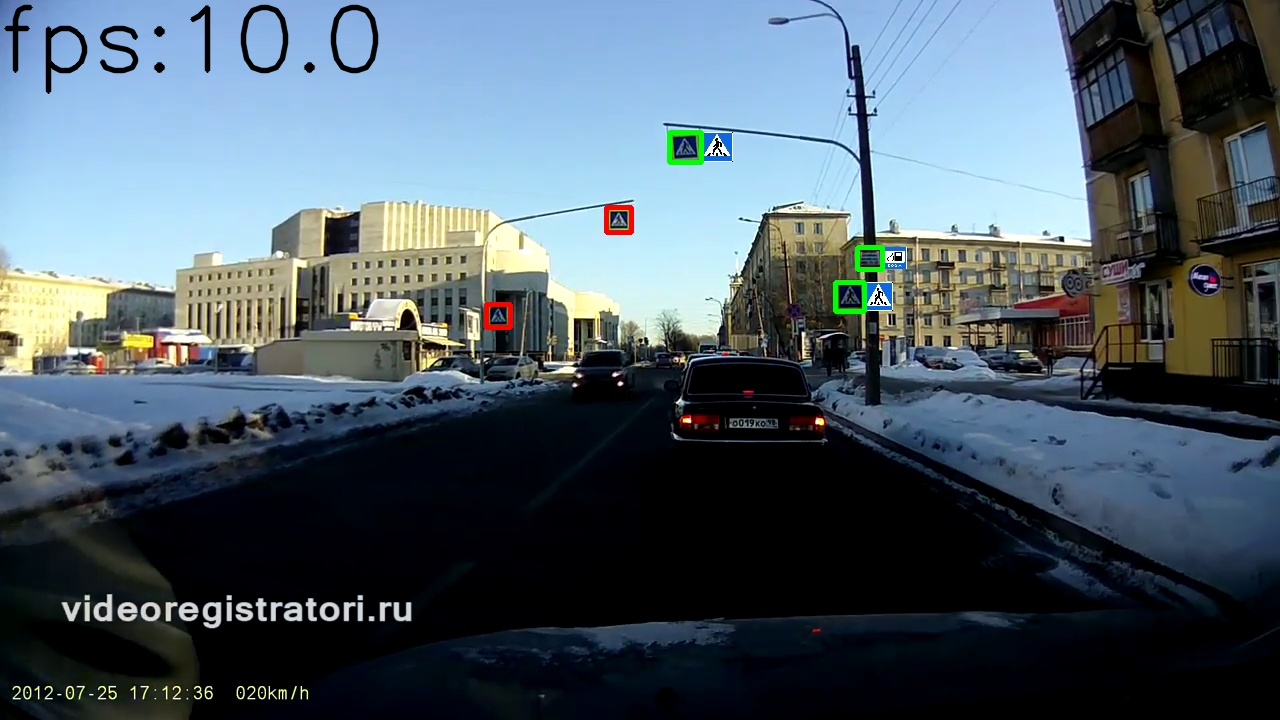

device cuda


KeyboardInterrupt: 

In [6]:
from IPython.display import display, Image
from utils.augmentations import letterbox

def FastTransformImgToDetectorInputFormat(frame, trained_img_size=(640, 640)):
    # print(frame.shape)
    # cv2.imshow('3', frame)
    # cv2.waitKey()
    frame = letterbox(frame, trained_img_size, auto=False)[0]
    # print(frame.shape)
    # cv2.imshow('3', frame)
    # cv2.waitKey()
    frame = frame.transpose((2, 0, 1))[::-1]
    frame = np.ascontiguousarray(frame)
    frame = torch.from_numpy(frame).float()
    frame /= 255
    frame = frame[None, ...]
    return frame

def FastTransformImgToClassifierInputFormat(img, trained_img_size=(64, 64)):
    img = cv2.resize(img, trained_img_size, interpolation=cv2.INTER_LANCZOS4)
    img_tnsr = torch.Tensor.permute(torch.Tensor(img), [2, 0, 1]).div(255)
    img_tnsr = img_tnsr[None, ...]
    return img_tnsr

def TransformClassifierPred(pred, le):
    pred = pred[0]
    argmax = np.argmax(pred)
    conf = pred[argmax]
    return conf, le.inverse_transform([argmax])[0]

LABEL_TO_PATH = {}
for _, row in STOCK_SIGNS_DATAFRAME.iterrows():
    LABEL_TO_PATH[row['SIGN']] = row['filepath']
    
def insertSignSubframe(frame, label, coords, df):
    # instance = df.at[label, 'SIGN'] #df['SIGN'] == label]
    # sing_subframe = cv2.imread(instance['filepath'].values[0])
    path = LABEL_TO_PATH[label]
    sing_subframe = cv2.imread(path)
    k = 1

    width = int((coords[2] - coords[0]) * k)
    height = int((coords[3] - coords[1]) * k) 
    dim = (width, height) 
        
    sing_subframe = cv2.resize(sing_subframe, dim)
    
    DELTA_Y = 0 # height
    DELTA_X = width
    try:
        frame[coords[1] + DELTA_Y:coords[1] + sing_subframe.shape[0] + DELTA_Y, 
              coords[0] + DELTA_X:coords[0] + sing_subframe.shape[1] + DELTA_X, 
              :] = sing_subframe
    except:
        pass
    return frame

video = cv2.VideoCapture(video_path)
display_handle1=display(1, display_id=True)

if LARGE:
    detector_img_size = 416
    detector_img_size = (detector_img_size, detector_img_size)
else:
    detector_img_size = 640
    detector_img_size = (detector_img_size, detector_img_size)
    
classifier_img_size = 40
classifier_img_size = (classifier_img_size, classifier_img_size)

torch.cuda.empty_cache()
print('device', device)
i = 0
while True:
    i += 1
    t0 = now()
    
    _, frame_src = video.read()
    
    if i % 2 == 0:
        for _ in range(8):
            _, frame_src = video.read()
        continue
    
    DETECTOR_INPUT = FastTransformImgToDetectorInputFormat(frame_src, trained_img_size=detector_img_size)
    DETECTOR_PREDS = DETECTOR_DETECT_INTEFACE(DETECTOR_INPUT.to(device))
    
    DETECTOR_PREDS_DATA = DETECTOR_DETECT_INTEFACE.translatePreds(DETECTOR_PREDS, 
                                                                  nn_img_size=detector_img_size, 
                                                                  source_img_size=frame_src.shape, 
                                                                  conf_thres=0.3, 
                                                                  max_det=10)
    for i in range(DETECTOR_PREDS_DATA['count']):
        COORD_ARR = [DETECTOR_PREDS_DATA['coords'][i][0], 
                     DETECTOR_PREDS_DATA['coords'][i][1], 
                     DETECTOR_PREDS_DATA['coords'][i][2], 
                     DETECTOR_PREDS_DATA['coords'][i][3]
                    ]

        CROPPED_IMG = frame_src[COORD_ARR[1]:COORD_ARR[3], 
                        COORD_ARR[0]:COORD_ARR[2]].copy()
                
        if CROPPED_IMG.shape[0] < 5 or CROPPED_IMG.shape[1] < 5:
            continue

        CLASSIFIER_INPUT = FastTransformImgToClassifierInputFormat(CROPPED_IMG, classifier_img_size)
        CLASSIFIER_PRED = CLASSIFIER(CLASSIFIER_INPUT.to(device)).cpu().detach().numpy()
        CLASSIFIER_PRED_CONF, CLASSIFIER_PRED_SIGN = TransformClassifierPred(CLASSIFIER_PRED, le)
        
        
        # CLASSIFIER_PRED_CONF, CLASSIFIER_PRED_SIGN = 1, '1'
        
        COLOR = (0, 255, 0)
        if CLASSIFIER_PRED_CONF < 0.2:
            CLASSIFIER_PRED_SIGN = '?'
            COLOR = (0, 0, 255)
        elif PLOT_SUBS:
            frame_src = insertSignSubframe(frame_src, CLASSIFIER_PRED_SIGN, COORD_ARR, STOCK_SIGNS_DATAFRAME)
        
        if SUPPRESS_TEXT:
            CLASSIFIER_PRED_SIGN = ''
        else:
            CLASSIFIER_PRED_SIGN += ':' + str(int(CLASSIFIER_PRED_CONF * 100)) + ':' + str(int(DETECTOR_PREDS_DATA['confs'][i] * 100))
        
        frame_src = cv2.rectangle(frame_src, (COORD_ARR[0], COORD_ARR[1]), 
                        (COORD_ARR[2], COORD_ARR[3]), 
                        COLOR, 
                        3)
        
        DELTA = 15
        
        frame_src = cv2.putText(frame_src, CLASSIFIER_PRED_SIGN, #str(round(DETECTOR_PREDS_DATA['confs'][i], 3)), 
                           (COORD_ARR[0], COORD_ARR[3] + DELTA),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.7, (255, 255, 255),
                           3, cv2.LINE_AA
                          )
        
        frame_src = cv2.putText(frame_src, CLASSIFIER_PRED_SIGN, #str(round(DETECTOR_PREDS_DATA['confs'][i], 3)), 
                           (COORD_ARR[0], COORD_ARR[3] + DELTA),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.7, (0, 0, 0),
                           1, cv2.LINE_AA
                          )
        
        # cv2.imshow('waitKey', CROPPED_IMG)
        # cv2.waitKey(0)
        
    dt = now() - t0
    frame_src = cv2.putText(frame_src, 
                            'fps:' + str(round(1 / dt.total_seconds() , 2)),
                            (0, 70),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            3, (0, 0, 0),
                            3, cv2.LINE_AA
                           )
    _, frame_src = cv2.imencode('.jpeg', frame_src)
    
    torch.cuda.empty_cache()
    
    display_handle1.update(Image(data=frame_src.tobytes()))


In [ ]:
frame_src.shape

In [ ]:
CROPPED_IMG.shape[0]